In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
train_data = pd.read_csv('/content/drive/MyDrive/train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'])
valid_data = pd.read_csv('/content/drive/MyDrive/test_data.txt', sep=':::', names=['Title', 'Description'])
valid_data_solution = pd.read_csv('/content/drive/MyDrive/test_data_solution.txt', sep=':::', names=['Title', 'Genre','Description'])

<ipython-input-68-83b6694dd7cf>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv('/content/drive/MyDrive/train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'])
<ipython-input-68-83b6694dd7cf>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  valid_data = pd.read_csv('/content/drive/MyDrive/test_data.txt', sep=':::', names=['Title', 'Description'])
<ipython-input-68-83b6694dd7cf>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you ca

In [69]:
print('Dataset information')
train_data.info()

Dataset information
<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [70]:
print('First Few rows of the Dataset')
train_data.head()

First Few rows of the Dataset


,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [71]:
print('Dataset description')
train_data.describe()

Dataset description


,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [72]:
print('Missing values in Dataset')
train_data.isnull().sum()

Missing values in Dataset


Title          0
Genre          0
Description    0
dtype: int64

In [73]:
print('Validation dataset')
valid_data.head()

Validation dataset


,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


In [74]:
valid_data.describe()

,Title,Description
count,54200,54200
unique,54200,54072
top,Edgar's Lunch (1998),Grammy - music award of the American academy ...
freq,1,10


In [75]:
class_Dist = train_data['Genre'].value_counts()
print(class_Dist)

Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64


In [76]:
imbalance_ratio = class_Dist.min() / class_Dist.max()
print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 0.009696613531183427


Class Distribution: Bar plot


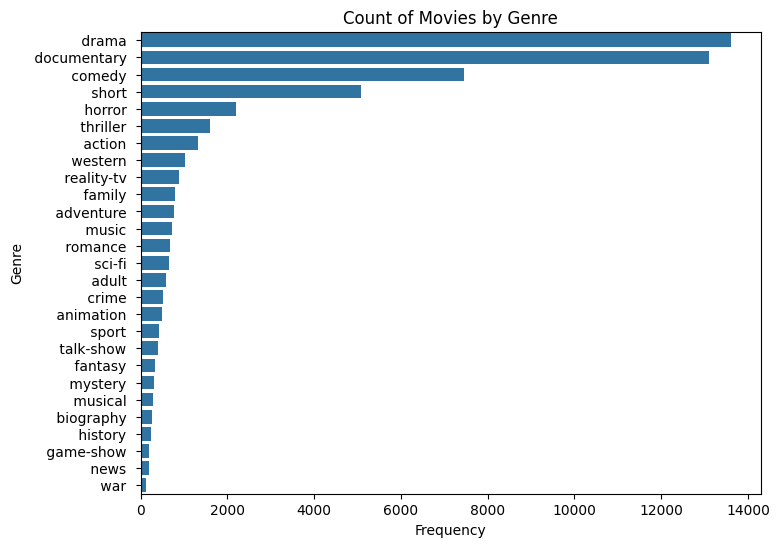

In [77]:
print('Class Distribution: Bar plot')
plt.figure(figsize=(8, 6))
sns.countplot(y='Genre', data=train_data, order=train_data['Genre'].value_counts().index)
plt.title('Count of Movies by Genre')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

In [78]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)


train_data['Description'] = train_data['Description'].apply(preprocess_text)
valid_data['Description'] = valid_data['Description'].apply(preprocess_text)

train_data['Description'].head()


1    listening conversation doctor parents oscar le...
2    a brother sister past incestuous relationship ...
3    as bus empties students field trip museum natu...
4    to help unemployed father make ends meet edith...
5    the film title refers bodies ground zero also ...
Name: Description, dtype: object

**TF-IDF Vectorization**

In [79]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Description'])
X_test_tfidf = tfidf_vectorizer.fit_transform(valid_data['Description'])

y = train_data['Genre']

x_train, x_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42)

Naive Bayes Classifier


In [80]:
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train, y_train)

MultinomialNB()

In [81]:
y_train_pred = nb_classifier.predict(x_test)

print("Accuracy on training set:", accuracy_score(y_test, y_train_pred))
print("Classification Report on training set:\n", classification_report(y_test, y_train_pred))

Accuracy on training set: 0.5199667988564051
Classification Report on training set:
                precision    recall  f1-score   support

      action        0.59      0.08      0.15       263
       adult        1.00      0.04      0.09       112
   adventure        0.38      0.04      0.07       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.42      0.46      1443
       crime        0.00      0.00      0.00       107
 documentary        0.58      0.89      0.70      2659
       drama        0.45      0.83      0.59      2697
      family        1.00      0.01      0.01       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.15      0.26        40
     history        0.00      0.00      0.00        45
      horror        0.73      0.34      0.46       431
       music        0.83      0.10      0.19       144
     musical        0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting with validation dataset

In [82]:
y_predict = nb_classifier.predict(X_test_tfidf)
valid_data['NB_Predicted_Genre'] = y_predict

valid_data.to_csv('NB_predicted_genres.csv', index=False)
print(valid_data)

                                  Title  \
1                 Edgar's Lunch (1998)    
2             La guerra de papá (1977)    
3          Off the Beaten Track (2010)    
4               Meu Amigo Hindu (2015)    
5                    Er nu zhai (1955)    
...                                 ...   
54196   "Tales of Light & Dark" (2013)    
54197      Der letzte Mohikaner (1965)    
54198              Oliver Twink (2007)    
54199                Slipstream (1973)    
54200        Curitiba Zero Grau (2010)    

                                             Description NB_Predicted_Genre  
1      brane loves life car apartment job especially ...             short   
2      spain march quico naughty child three belongin...       documentary   
3      one year life albin family shepherds north tra...       documentary   
4      his father died spoken brother years serious c...       documentary   
5      before known internationally martial arts supe...       documentary   
...            

Logistic Regression Classifier


In [83]:
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(x_train, y_train)
y_train_pred = lr_classifier.predict(x_test)

print("Accuracy on training set:", accuracy_score(y_test, y_train_pred))
print("Classification Report on training set:\n", classification_report(y_test, y_train_pred))

Accuracy on training set: 0.579728857327308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report on training set:
                precision    recall  f1-score   support

      action        0.50      0.25      0.33       263
       adult        0.73      0.21      0.33       112
   adventure        0.46      0.15      0.23       139
   animation        0.55      0.06      0.10       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.58      0.55      1443
       crime        0.17      0.01      0.02       107
 documentary        0.67      0.85      0.75      2659
       drama        0.54      0.78      0.64      2697
      family        0.38      0.08      0.13       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.94      0.40      0.56        40
     history        0.00      0.00      0.00        45
      horror        0.63      0.55      0.59       431
       music        0.67      0.49      0.56       144
     musical        0.33      0.02      0.04        50
     mystery        0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting with validation dataset


In [84]:
Predicted_Genre = lr_classifier.predict(X_test_tfidf)
valid_data['LR_Predicted_Genre'] = Predicted_Genre

valid_data.to_csv('LR_predicted_genres.csv', index=False)
print(valid_data)


                                  Title  \
1                 Edgar's Lunch (1998)    
2             La guerra de papá (1977)    
3          Off the Beaten Track (2010)    
4               Meu Amigo Hindu (2015)    
5                    Er nu zhai (1955)    
...                                 ...   
54196   "Tales of Light & Dark" (2013)    
54197      Der letzte Mohikaner (1965)    
54198              Oliver Twink (2007)    
54199                Slipstream (1973)    
54200        Curitiba Zero Grau (2010)    

                                             Description NB_Predicted_Genre  \
1      brane loves life car apartment job especially ...             short    
2      spain march quico naughty child three belongin...       documentary    
3      one year life albin family shepherds north tra...       documentary    
4      his father died spoken brother years serious c...       documentary    
5      before known internationally martial arts supe...       documentary    
...      

Support Vector Machines classifier

In [85]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)

y_train_pred = lr_classifier.predict(x_test)

print("Accuracy on training set:", accuracy_score(y_test, y_train_pred))
print("Classification Report on training set:\n", classification_report(y_test, y_train_pred))

Accuracy on training set: 0.579728857327308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report on training set:
                precision    recall  f1-score   support

      action        0.50      0.25      0.33       263
       adult        0.73      0.21      0.33       112
   adventure        0.46      0.15      0.23       139
   animation        0.55      0.06      0.10       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.58      0.55      1443
       crime        0.17      0.01      0.02       107
 documentary        0.67      0.85      0.75      2659
       drama        0.54      0.78      0.64      2697
      family        0.38      0.08      0.13       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.94      0.40      0.56        40
     history        0.00      0.00      0.00        45
      horror        0.63      0.55      0.59       431
       music        0.67      0.49      0.56       144
     musical        0.33      0.02      0.04        50
     mystery        0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting with validation data

In [86]:
svm_pred = svm_classifier.predict(X_test_tfidf)
valid_data['SVM_Predicted_Genre'] = svm_pred

valid_data.to_csv('SVM_predicted_genres.csv', index=False)
print(valid_data)

                                  Title  \
1                 Edgar's Lunch (1998)    
2             La guerra de papá (1977)    
3          Off the Beaten Track (2010)    
4               Meu Amigo Hindu (2015)    
5                    Er nu zhai (1955)    
...                                 ...   
54196   "Tales of Light & Dark" (2013)    
54197      Der letzte Mohikaner (1965)    
54198              Oliver Twink (2007)    
54199                Slipstream (1973)    
54200        Curitiba Zero Grau (2010)    

                                             Description NB_Predicted_Genre  \
1      brane loves life car apartment job especially ...             short    
2      spain march quico naughty child three belongin...       documentary    
3      one year life albin family shepherds north tra...       documentary    
4      his father died spoken brother years serious c...       documentary    
5      before known internationally martial arts supe...       documentary    
...      

In [87]:
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)
with open('nb_classifier.pkl', 'wb') as file:
    pickle.dump(nb_classifier, file)
with open('lr_classifier.pkl', 'wb') as file:
    pickle.dump(lr_classifier, file)
with open('svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

print("Models pickled successfully.")

Models pickled successfully.
